In [1]:
import numpy as np
import h5py
import scipy.signal
import pandas as pd
import matplotlib.pyplot as plt
from skimage.util.montage import montage2d
from skimage.color import label2rgb
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
import os
%matplotlib inline

0.000138547444068
using -1000.000000 as threshold for ct
using 0.359708 as threshold for pet
0.00152483823248
using -1000.000000 as threshold for ct
using 0.621459 as threshold for pet
0.000174232047113
using -1000.000000 as threshold for ct
using 0.100482 as threshold for pet


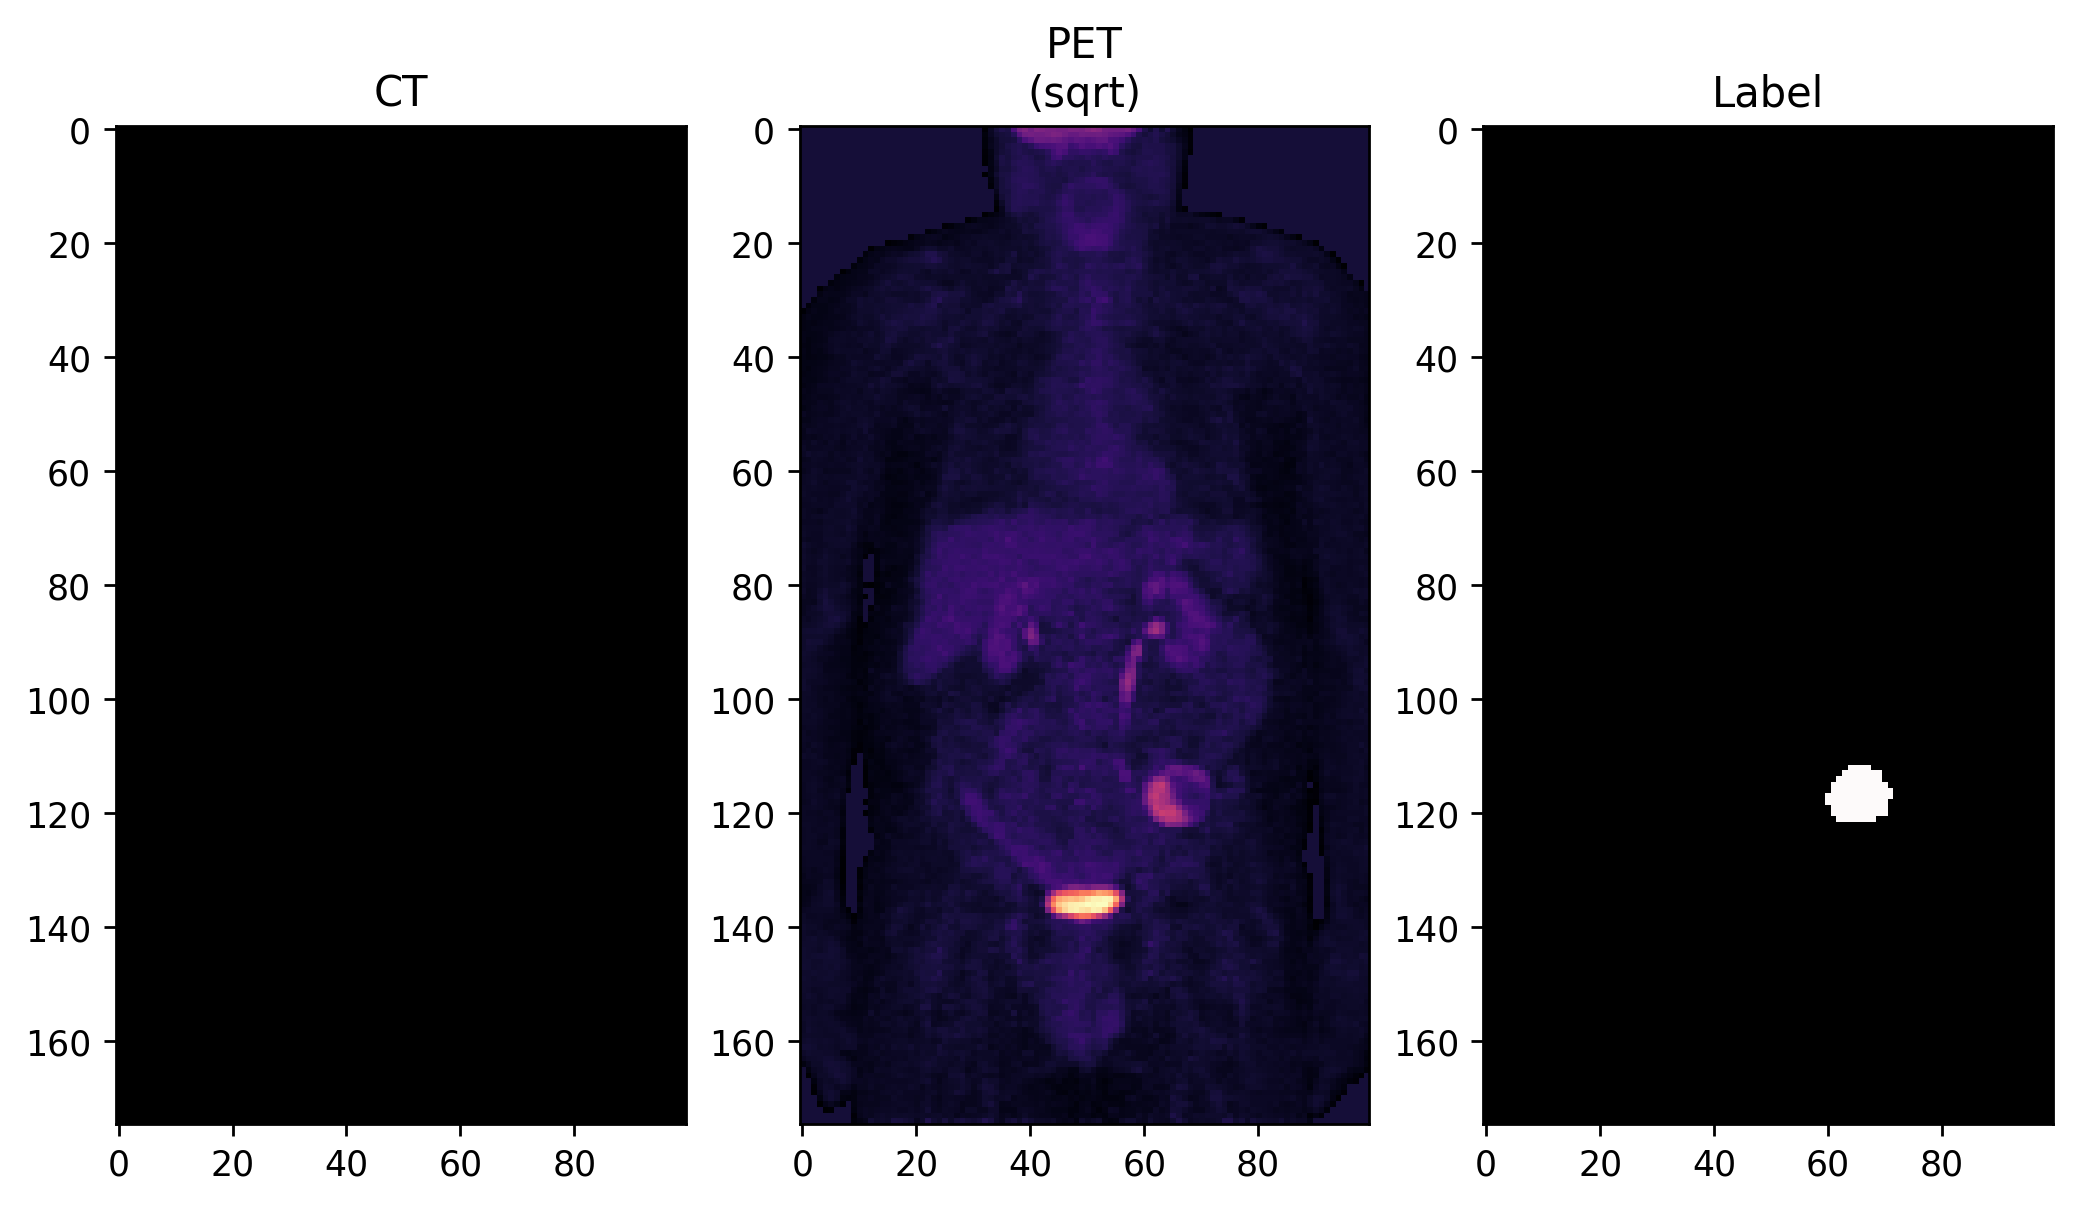

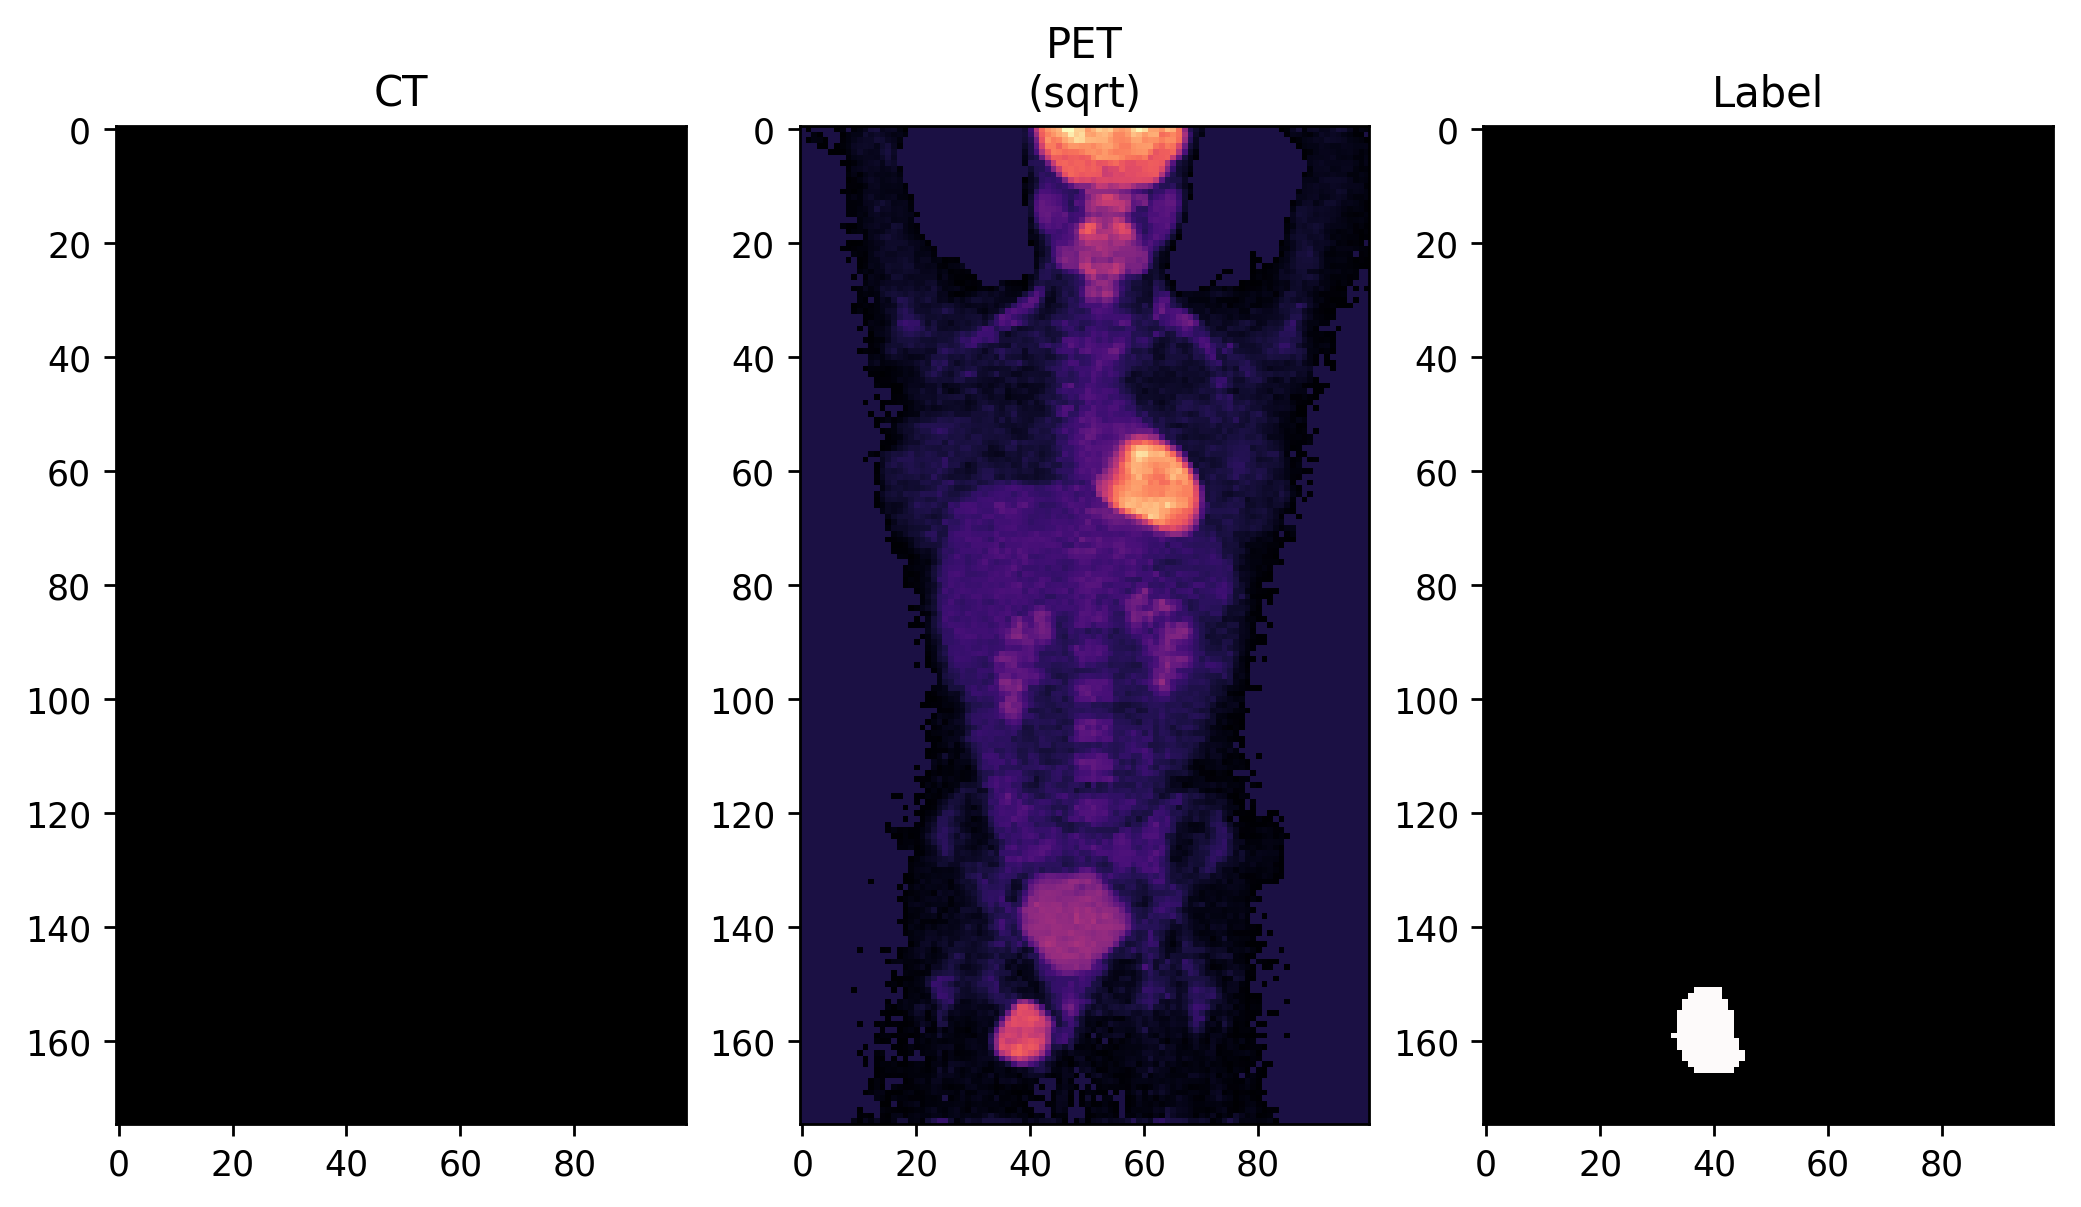

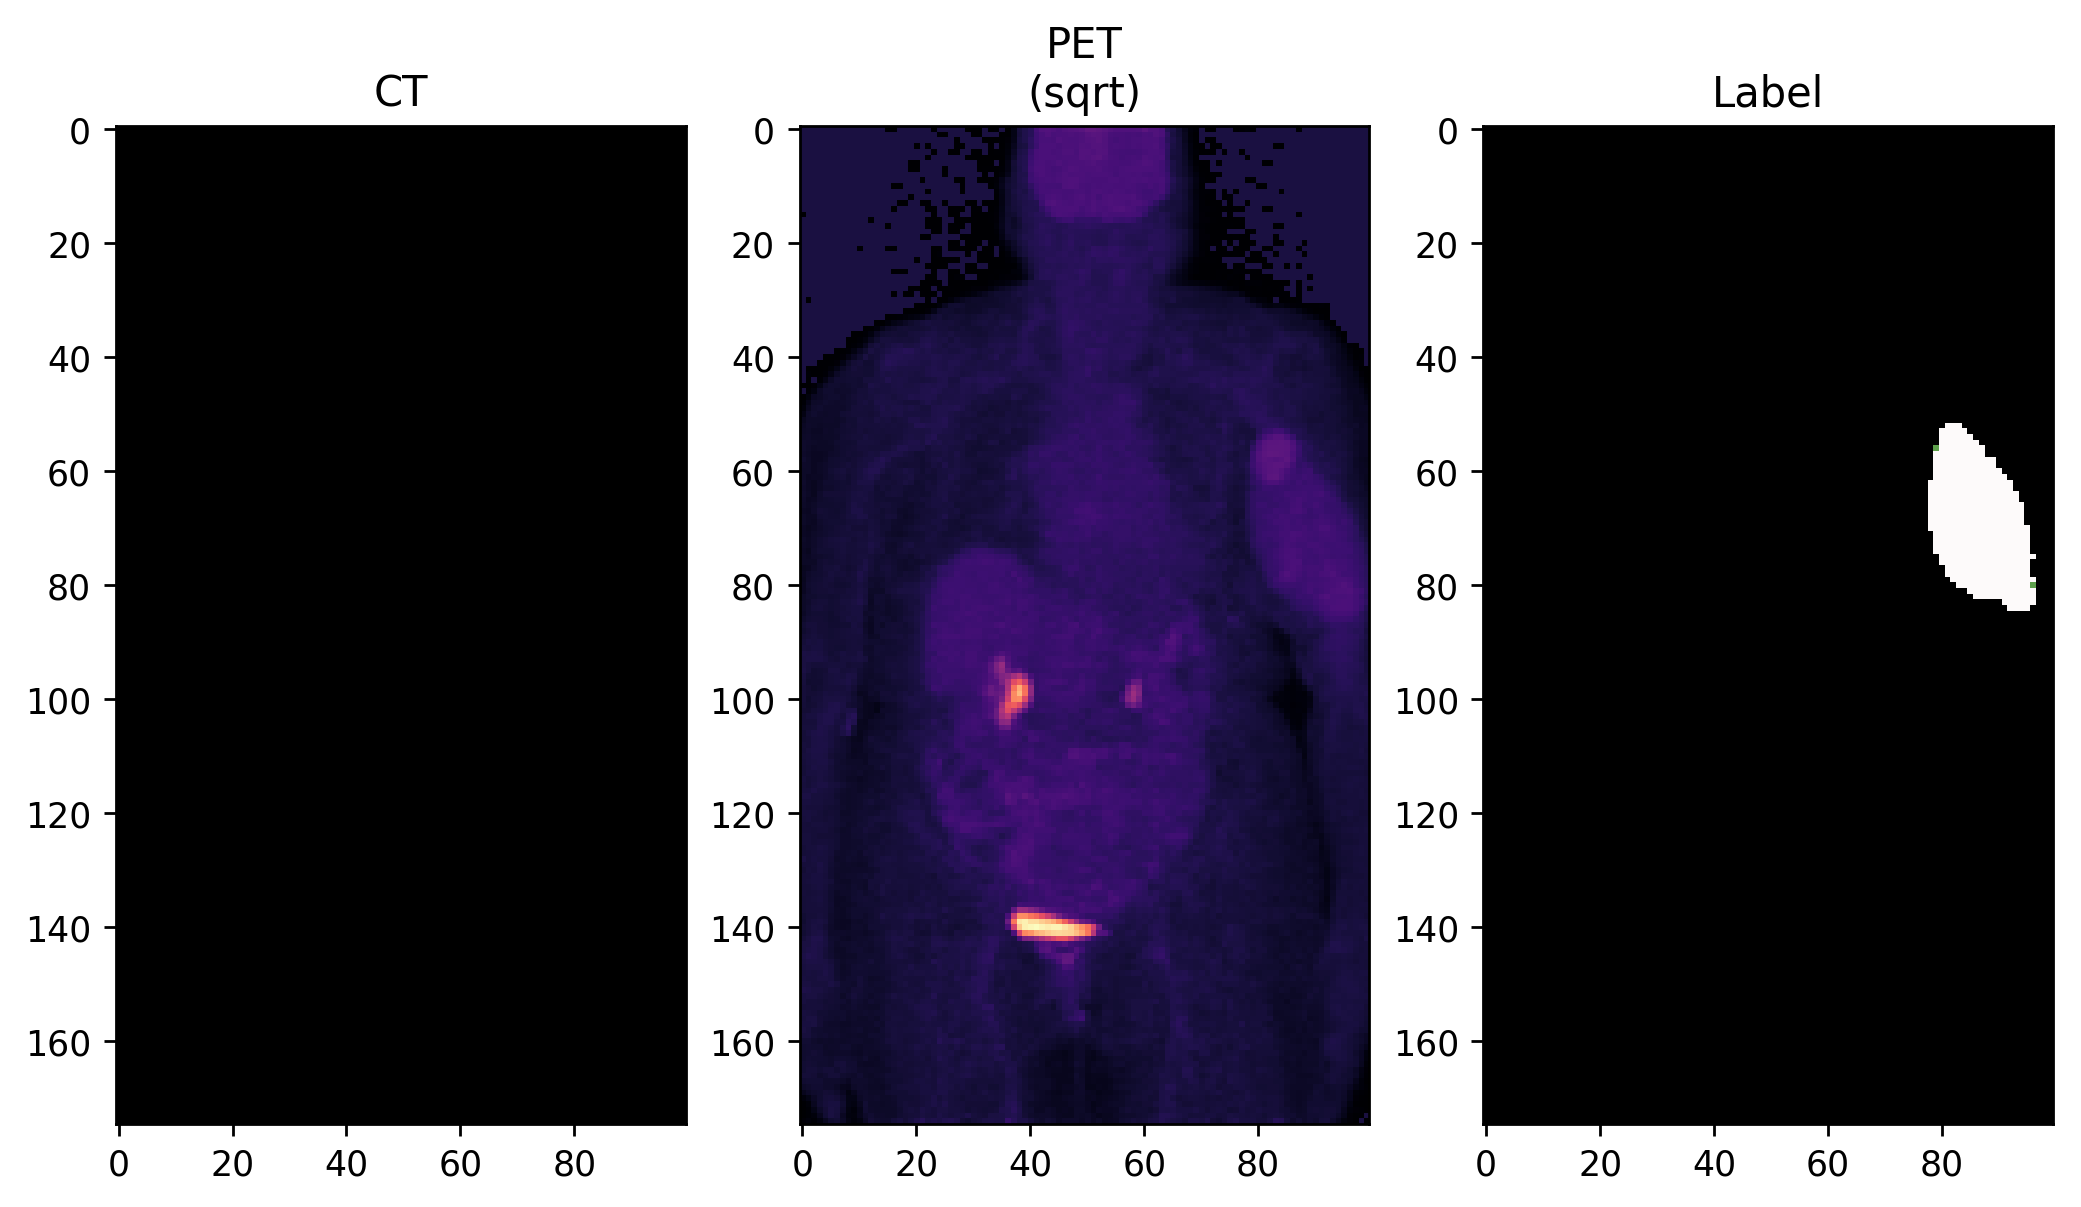

In [12]:
ct_data, pet_data, label_data = [], [], []
with h5py.File(os.path.join('..','input','lab_petct_vox_5.00mm.h5'),'r') as p_data:
    num=3
    #print(p_data['ct_data'].values()[0])
    for ct_img, pet_img, lab_img in zip(
                                   p_data['ct_data'].values(),
                                   p_data['pet_data'].values(),
                                   p_data['label_data'].values()
                                                           ):
        fig, (c_ax1, c_ax2, c_ax3) = plt.subplots(1, 3, figsize=(10, 10), dpi = 250)
        
        ct_data.append(np.sum(ct_img,1))
        pet_data.append(np.sum(pet_img,1))
        label_data.append(np.sum(lab_img,1))
        num=num-1
        print(pet_img[10,10,10])
        css=np.sum(ct_img,1).squeeze()[::-1,:]
        threshold = np.mean(ct_img[0:100,0:5,0:5])
        print('using %f as threshold for ct' % threshold)
        css[np.where(css<threshold)] = 255
        c_ax1.imshow(css, cmap = 'bone')
        c_ax1.set_title('CT')
        c_ax1.axis('on')

        css=np.sqrt(np.max(pet_img,1)).squeeze()[::-1,:]
        threshold = np.mean(css[0:40,0:20])
        print('using %f as threshold for pet' % threshold)
        css[np.where(css<threshold)] = 1
        c_ax2.imshow(css, cmap = 'magma')
        c_ax2.set_title('PET\n(sqrt)')
        c_ax2.axis('on')
        
        c_ax3.imshow(np.max(lab_img,1).squeeze()[::-1,:], cmap = 'gist_earth')
        c_ax3.set_title('Label')
        c_ax3.axis('on')
        if num == 0:
            break
    #print(pet_data[0].shape)
    #print(np.sum(pet_data[0],1).shape)
    #print(np.max(np.sum(pet_data[::-1,:],1)))
    

In [58]:
ct_tiles = []
pet_tiles = []
lab_tiles = []
tile_size=16
stride=3
for ct_img, pet_img, label in zip(ct_data, pet_data, label_data):
    for i in range(0,  ct_img.shape[0], tile_size):
        for j in range(0,  ct_img.shape[1], tile_size):
            for i_k in range(0, tile_size, stride):
                c=0
                for j_k in range(0, tile_size, stride):
                    c=c+1
                    ct_tiles += [ct_img[i+i_k:(i+i_k+tile_size),j+j_k:(j+j_k+tile_size)]]
                    pet_tiles += [pet_img[i+i_k:(i+i_k+tile_size),j+j_k:(j+j_k+tile_size)]]
                    lab_tiles += [label[i+i_k:(i+i_k+tile_size),j+j_k:(j+j_k+tile_size)]]


## Removing tiles of wrong shape

In [59]:
ct_tiles = [c_tile for c_tile in ct_tiles if c_tile.shape == (tile_size,tile_size)]
pet_tiles = [c_tile for c_tile in pet_tiles if c_tile.shape == (tile_size,tile_size)]
lab_tiles = [c_tile for c_tile in lab_tiles if c_tile.shape == (tile_size,tile_size)]


#fig, (ax1, ax2, ax3,ax4,ax5,ax6) = plt.subplots(1,6, figsize=(50,50))
#ax1.imshow(montage2d(np.stack(n_ct_tiles,0)), cmap = 'bone')
#ax2.imshow(montage2d(np.stack(n_pet_tiles,0)), cmap = 'bone')
#ax3.imshow(montage2d(np.stack(n_lab_tiles,0)), cmap = 'gist_earth')
#ax4.imshow(montage2d(np.stack(n_ct_tiles2,0)), cmap = 'bone')
#ax5.imshow(montage2d(np.stack(n_pet_tiles2,0)), cmap = 'bone')
#ax6.imshow(montage2d(np.stack(n_lab_tiles2,0)), cmap = 'gist_earth')

## Removing predominantly black tiles

In [99]:
ct_tiles_final, pet_tiles_final, lab_tiles_final = zip(*[(c_tile, p_tile, l_tile) 
      for c_tile, p_tile, l_tile in zip(ct_tiles, pet_tiles, lab_tiles)
     if np.mean(c_tile) > -80000 and np.mean(p_tile) > .08])
print('%d tiles removed' % (len(ct_tiles)-len(ct_tiles_final)))

840 tiles removed


## Splitting tiles into training and validation set

In [100]:
print(len(pet_tiles))
l = len(pet_tiles) - 1920

ct_tiles_test = ct_tiles_final[l:]
pet_tiles_test = pet_tiles_final[l:]
lab_tiles_test = lab_tiles_final[l:]
ct_tiles_train = ct_tiles_final[:l]
pet_tiles_train = pet_tiles_final[:l]
lab_tiles_train = lab_tiles_final[:l]

5760


In [101]:
lab_score = [np.mean(c_tile) for c_tile in lab_tiles_train]
lab_score_test = [np.mean(c_tile) for c_tile in lab_tiles_test]
ct_tile_flat = [c_tile.flatten() for c_tile in ct_tiles_train]
ct_tile_flat_test = [c_tile.flatten() for c_tile in ct_tiles_test]
pet_tile_flat = [c_tile.flatten() for c_tile in pet_tiles_train]
pet_tile_flat_test = [c_tile.flatten() for c_tile in pet_tiles_test]
lab_class = [c_score > 0 for c_score in lab_score]
lab_class = [c_score > 0 for c_score in lab_score_test]


In [88]:
train_tiles, test_tile, train_score, test_score = np.stack(pet_tile_flat), np.stack(pet_tile_flat_test), lab_score, lab_score_test
#print('Training size', train_tiles.shape, 'Testing size', test_tile.shape)
#print('Train tumor tiles', np.where(train_score), 'Test tumor tiles', np.where(test_score))

ValueError: need at least one array to stack

In [78]:
from sklearn.neighbors import KNeighborsRegressor
knn1_model = KNeighborsRegressor(2, algorithm = 'kd_tree')

In [79]:
knn1_model.fit(train_tiles, train_score)

KNeighborsRegressor(algorithm='kd_tree', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=2, p=2,
          weights='uniform')

In [80]:
test_predictions = knn1_model.predict(test_tile)
#print('Predicted Results', test_predictions)
#print(np.array(train_score)[np.where(np.array(train_score)>5)])
print(knn1_model.kneighbors(np.array(test_tile),2))

(array([[  23.96126581,   25.43731491],
       [  26.7331517 ,   28.45644505],
       [  32.31716692,   35.28130876],
       ..., 
       [ 207.07974628,  214.70405449],
       [ 187.57308546,  188.29770318],
       [ 103.82277002,  108.32578827]]), array([[3834, 3828],
       [3829, 3835],
       [3830, 3836],
       ..., 
       [3559, 3408],
       [3560, 3409],
       [3610, 3575]]))


In [81]:
from sklearn.metrics import confusion_matrix
confusion_matrix(np.array(test_score)>0, np.array(test_predictions)>0)

array([[1381,   26],
       [ 132,   13]])

(-0.1, 1.1)

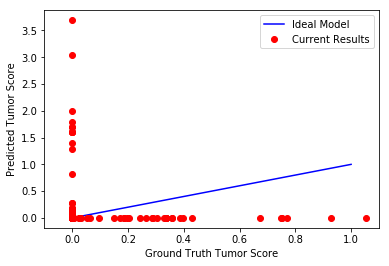

In [82]:
fig, ax1 = plt.subplots(1,1)
ax1.plot([0,1], [0,1], 'b-', label = 'Ideal Model')
ax1.plot(test_score, test_predictions, 'ro', label = 'Current Results')
ax1.set_xlabel('Ground Truth Tumor Score')
ax1.legend()
ax1.set_ylabel('Predicted Tumor Score')
ax1.set_xlim(-0.1,1.1)

In [83]:
f1score = f1_score(np.array(test_score)>0, np.array(test_predictions)>0)
print(f1score)

0.141304347826


In [84]:
rscore=roc_auc_score(np.array(test_score)>0, np.array(test_predictions)>0)
print(rscore)

0.535588069505
